## Fine-tune TrOCR on the IAM Handwriting Database

In this notebook, we are going to fine-tune a pre-trained TrOCR model on coustom dataset, a collection of annotated images of handwritten text.

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text.

This figure gives a good overview of the model (from the original paper):

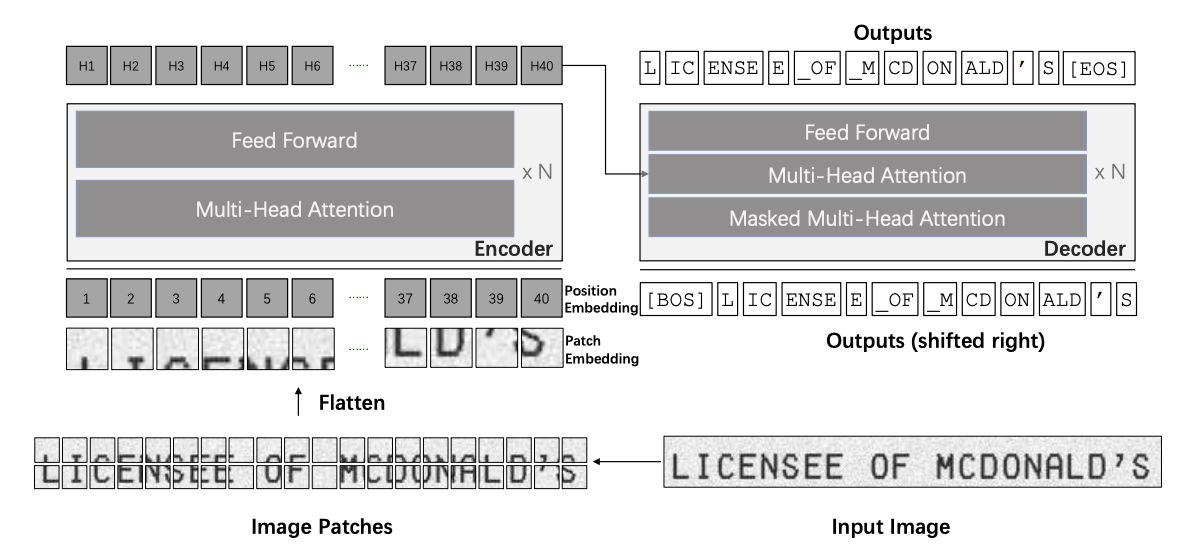

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


We will fine-tune the model using the Seq2SeqTrainer, which is a subclass of the 🤗 Trainer that lets you compute generative metrics such as BLEU, ROUGE, etc by doing generation (i.e. calling the `generate` method) inside the evaluation loop.



## Set-up environment

First, let's install the required libraries:
* Transformers (for the TrOCR model)
* Datasets & Jiwer (for the evaluation metric)

We will not be using HuggingFace Datasets in this notebook for data preprocessing, we will just create a good old basic PyTorch Dataset.

This is a modified version with coustum dataset made for the Pattern recognition Project.


In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q datasets jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.8 MB/s eta 0:00:00


In [ ]:
#Added cell
# 1. Import necessary libraries
import glob
import os

# 2. Unzip the file
!unzip traind.zip

# 3. Use glob to find image files (assuming images are JPG)
image_files = glob.glob("train_0001.png/*.png")  # Adjust extension as needed

# 4. Print the image files for verification
for img in image_files:
    print(img)

Archive:  traind.zip
   creating: train/
  inflating: train/train_0000.png    
  inflating: train/train_0001.png    
  inflating: train/train_0002.png    
  inflating: train/train_0003.png    
  inflating: train/train_0004.png    
  inflating: train/train_0005.png    
  inflating: train/train_0006.png    
  inflating: train/train_0007.png    
  inflating: train/train_0008.png    
  inflating: train/train_0009.png    
  inflating: train/train_0010.png    
  inflating: train/train_0011.png    
  inflating: train/train_0012.png    
  inflating: train/train_0013.png    
  inflating: train/train_0014.png    
  inflating: train/train_0015.png    
  inflating: train/train_0016.png    
  inflating: train/train_0017.png    
  inflating: train/train_0018.png    
  inflating: train/train_0019.png    
  inflating: train/train_0020.png    
  inflating: train/train_0021.png    
  inflating: train/train_0022.png    
  inflating: train/train_0023.png    
  inflating: train/train_0024.png    
  inflati

In [ ]:
#Added cell
import pandas as pd
import json
import os


df = pd.read_csv("train.csv", sep=",", header=None, names=["file_name", "text"])  # Komma


bilder_ordner = "/content/images/"  # 🔽 Pfad zu deinem Bilder-Ordner
dataset = []
for _, row in df.iterrows():
    dataset.append({
        "file_name": os.path.join(bilder_ordner, row["file_name"].strip()),  # Leerzeichen entfernen
        "text": row["text"].strip()  # Leerzeichen entfernen
    })

import pandas as pd

# 🔽 Anpassen je nach Trennzeichen in deiner CSV!
df = pd.read_csv("train.csv", sep=",", header=None, names=["file_name", "text"], encoding="utf-8")  # Für Komma


# 3. JSON speichern
with open("train.json", "w") as f:
    json.dump(dataset, f, indent=4)


df.head()

file_name         text
0  train_0000.png  Darstellung
1  train_0001.png  Darstellung
2  train_0002.png  Darstellung
3  train_0003.png  Darstellung
4  train_0004.png  Darstellung

Prepare the data

In [ ]:
import pandas as pd

# Load your CSV (adjust `sep` if needed)
df = pd.read_csv("train.csv", sep=",", header=None, names=["file_name", "text"], encoding="utf-8")

# Strip whitespace from paths/text
df["file_name"] = df["file_name"].str.strip()
df["text"] = df["text"].str.strip()

# Split into train/test (80/20 split)
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [ ]:
!pip install -q datasets jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.7 MB/s eta 0:00:00


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [ ]:
#Modified cell
import torch
from torch.utils.data import Dataset
from PIL import Image


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, processor, image_dir="/content/train", max_target_length=128):
        self.df = df
        self.processor = processor
        self.image_dir = image_dir
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df.iloc[idx]["file_name"]
        text = self.df.iloc[idx]["text"]

        # Load image (convert to RGB)
        image = Image.open(f"{self.image_dir}/{file_name}").convert("RGB")

        # Process image and text
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_target_length,
            truncation=True
        ).input_ids

        # Replace padding token with -100 (ignored by loss)
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(labels)
        }

#Orignal cell

""" class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding"""

' class IAMDataset(Dataset):\n    def __init__(self, root_dir, df, processor, max_target_length=128):\n        self.root_dir = root_dir\n        self.df = df\n        self.processor = processor\n        self.max_target_length = max_target_length\n\n    def __len__(self):\n        return len(self.df)\n\n    def __getitem__(self, idx):\n        # get file name + text\n        file_name = self.df[\'file_name\'][idx]\n        text = self.df[\'text\'][idx]\n        # prepare image (i.e. resize + normalize)\n        image = Image.open(self.root_dir + file_name).convert("RGB")\n        pixel_values = self.processor(image, return_tensors="pt").pixel_values\n        # add labels (input_ids) by encoding the text\n        labels = self.processor.tokenizer(text,\n                                          padding="max_length",\n                                          max_length=self.max_target_length).input_ids\n        # important: make sure that PAD tokens are ignored by the loss function\n    

Let's initialize the training and evaluation datasets:

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# Create datasets
train_dataset = CustomDataset(train_df, processor)
eval_dataset = CustomDataset(test_df, processor)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 800
Number of validation examples: 200


Let's verify an example from the training dataset:

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

AttributeError: 'CustomDataset' object has no attribute 'root_dir'

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Mögliche Instabilitäten


## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    report_to="none",
    predict_with_generate=True,
    eval_strategy="steps",
    #evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [ ]:

import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
<ipython-input-23-614628956>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1730: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=300, training_loss=1.4361072727044424, metrics={'train_runtime': 263.2017, 'train_samples_per_second': 9.118, 'train_steps_per_second': 1.14, 'total_flos': 2.1237490815860736e+18, 'train_loss': 1.4361072727044424, 'epoch': 3.0})

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [ ]:
!ls /content/checkpoint-300

config.json		preprocessor_config.json  trainer_state.json
generation_config.json	rng_state.pth		  training_args.bin
model.safetensors	scaler.pt
optimizer.pt		scheduler.pt


In [ ]:
!zip -r checkpoint-300.zip /content/checkpoint-300

  adding: content/checkpoint-300/ (stored 0%)
  adding: content/checkpoint-300/training_args.bin (deflated 52%)
  adding: content/checkpoint-300/model.safetensors (deflated 7%)
  adding: content/checkpoint-300/preprocessor_config.json (deflated 47%)
  adding: content/checkpoint-300/config.json (deflated 64%)
  adding: content/checkpoint-300/trainer_state.json (deflated 82%)
  adding: content/checkpoint-300/rng_state.pth (deflated 25%)
  adding: content/checkpoint-300/scheduler.pt (deflated 55%)
  adding: content/checkpoint-300/scaler.pt (deflated 60%)
  adding: content/checkpoint-300/optimizer.pt (deflated 20%)
  adding: content/checkpoint-300/generation_config.json (deflated 40%)


In [ ]:
from google.colab import files
files.download("checkpoint-300.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# Load processor from original pre-trained model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")  # or "microsoft/trocr-base-stage1"

# Load your fine-tuned model
model = VisionEncoderDecoderModel.from_pretrained("/content/checkpoint-300").to("cuda")

In [ ]:
#Added cell
from PIL import Image

# Load and process image
image = Image.open("train_0025.png").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values.to("cuda")

# Generate text
generated_ids = model.generate(pixel_values)
print(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])

Bverbeitung
